Marco Bjarne Schuster (7008806)(masc00008@stud.uni-saarland.de), Deepanshu Mehta (7011083)(deme00001@stud.uni-saarland.de)

# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
!pip install scipy==1.1.0

In [1]:
# only use specific GPU on the server
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [18]:
# improve resolution of figures
import matplotlib
matplotlib.rcParams.update({'figure.dpi': 150})

### 1.1 Loading the dataset

In [3]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [4]:
from torchvision.models import resnet18
from torch import nn
class ResSeg(nn.Module):
    """Simple image segmentation model that consists of a headless ResNet18 and a transposed convolutional layer

    Attributes
    ----------
    encoding: trochvision.models.resnet18
        pretrained ResNet18 as the encoding part of the network
    decoding: torch.nn.ConvTranspose2d
        transposed convolutionaly layer as the decoding part of the network
    res_out: torch.tensor
        buffer used to store the headless output of the ResNet18
    """
    def __init__(self):
        super().__init__()
        
        self.encoding = resnet18(pretrained=True)
        self.decoding = nn.ConvTranspose2d(512, 21, kernel_size=80, stride=30, padding=10, output_padding=2)
    
    def forward(self, x):
        """Computes the forward pass through the network

        Parameters
        ----------
        x : torch.tensor
            Network input of shape (batch_size, 3, height, width)

        Returns
        -------
        torch.tensor
            Network output with shape (batch_size, 21, height, width)
        """
        self.encoding.layer4.register_forward_hook(self.hook)
        self.encoding(x)
        out = self.decoding(self.res_out)
        return out
    
    def hook(self, module, x, y):
        """Hook function used to get headless ResNet18 output

        Sets the res_out attribute to the detached output tensor of the module
        when a forward pass through ResNet18 is performed.

        Parameters
        ----------
        module : torch.nn.Module
            The module the hook was registered on
        x : torch.tensor
            Input tensor of the module the hook was registered on
        y : torch.tensor
            Output tensor of the module the hook was registered on
        """
        self.res_out = y.detach()

In [5]:
# create the model and move it to the GPU
model = ResSeg()
_ = model.cuda()

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [6]:
local_path = 'VOCdevkit/VOC2012'  # modify it according to your device

batch_size_train = 32
epochs = 20
learning_rate = 1e-4
betas = (0.9, 0.999)

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [7]:
# dataset variable for training
train_data = pascalVOCDataset(root=local_path, is_transform=True, test_mode=None , sbd_path=local_path, split='train')
# dataloader variable for training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [8]:
# save the randomly initialized model as "epoch 0" model
torch.save(model.state_dict(), "model_state_epoch_" + str(0) + ".pt")

# loop through epochs
for epoch in range(epochs):
    # print current epoch
    print('Epoch {}/{}'.format(epoch+1, epochs))
    print('-' * 10)

    model.train(True)  # set training mode for model
    running_loss = 0.0 # initialize running loss

    # iterate over mini-batches
    for i, data in enumerate(train_loader, 0):
        # get the inputs and target outputs, move them to GPU
        x, y = data 
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad() # zero the gradients
        outputs = model(x) # forward pass
        loss = loss_fn(outputs, y) # compute loss

        loss.backward() # backward pass
        optimizer.step() # take optimization step

        # add the loss contribution of the current batch to the running loss
        running_loss += loss.item() * len(y)

        # print loss updates every 10 batches
        if i % 10 == 0:
            print('Current step: {}  Loss: {}'.format(i, loss))

    # compute the average epoch loss as the weighted average over batch losses
    epoch_loss = running_loss / len(train_loader.dataset)

    # print the average epoch loss
    print('Epoch {} Loss: {:.4f}'.format(epoch+1, epoch_loss))

    # save the model after the epoch
    torch.save(model.state_dict(), "model_state_epoch_" + str(epoch+1) + ".pt")

Epoch 1/20
----------
Current step: 0  Loss: 3.0563817024230957
Current step: 10  Loss: 1.9430466890335083
Current step: 20  Loss: 1.6230242252349854
Current step: 30  Loss: 1.6663801670074463
Current step: 40  Loss: 1.5922776460647583
Epoch 1 Loss: 1.7715
Epoch 2/20
----------
Current step: 0  Loss: 1.2636470794677734
Current step: 10  Loss: 1.268994927406311
Current step: 20  Loss: 1.0662710666656494
Current step: 30  Loss: 0.8629821538925171
Current step: 40  Loss: 1.0539028644561768
Epoch 2 Loss: 1.1571
Epoch 3/20
----------
Current step: 0  Loss: 1.069894790649414
Current step: 10  Loss: 0.9170409440994263
Current step: 20  Loss: 0.9729390144348145
Current step: 30  Loss: 0.9183979034423828
Current step: 40  Loss: 1.1652352809906006
Epoch 3 Loss: 0.9323
Epoch 4/20
----------
Current step: 0  Loss: 0.8777056932449341
Current step: 10  Loss: 0.9105169177055359
Current step: 20  Loss: 1.0310959815979004
Current step: 30  Loss: 0.8504658937454224
Current step: 40  Loss: 0.725313723087

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

In [10]:
def evaluate(model):
    """Computes the image segmentation evaluation metrics for the given model

    The metrics are computed per training batch and averaged in the end.
    Moreover a progress bar is shown since the evaluation is quite time consuming.

    Parameters
    ----------
    model : torch.nn.Module
        The model to evaluate
    
    Returns
    -------
    tuple
        Tuple containing the loss, the F1 score and the AUC score (currently not implemented, always 0)
    """
    model.train(False) # use evaluation mode of model
    with torch.no_grad(): # prevent gradient computation for better performance
        # initialize weighted sums for performance measures
        f1 = 0.0
        auc = 0.0
        loss = 0.0
        
        # loop through batches with progress indicator
        for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
            # get the inputs and target outputs, move them to GPU
            x, y = data
            x = x.cuda()
            y = y.cuda()
            
            outputs = model(x) # forward pass
            loss += loss_fn(outputs, y).item() * len(y) # add current batch' loss contribution
            
            # compute scores so that spatial dimensions are transformed into sample dimensions
            # this is needed to match sklearn's AUC interface
            scores = torch.nn.functional.softmax(outputs, dim=1) # get probabilities
            scores = scores.permute(1, 0, 2, 3) # make channel dimension the first dimension
            # collapse sample and spatial dimensions
            scores = scores.reshape((scores.shape[0], scores.shape[1] * scores.shape[2] * scores.shape[3]))
            scores = scores.permute(1, 0) # make sample dimension the first dimension
            scores = scores.cpu()
            
            # transform target's spatial dimensions into sample dimension
            targets = y.reshape((y.shape[0] * y.shape[1] * y.shape[2]))
            targets = targets.cpu()

            # compute F1 score
            f1 += f1_score(targets, torch.argmax(scores, dim=1), average="macro") * len(y)
            # compute AUC score
            auc += roc_auc_score(targets, scores, average="macro", multi_class="ovr") * len(y)
            
    # average loss over batches
    loss = loss / len(train_loader.dataset)
    f1 = f1 / len(train_loader.dataset)
    auc = auc / len(train_loader.dataset)

    return loss, f1, auc

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [11]:
# initialize lists for all epoch's scores
f1s = []
aucs = []
losses = []
# loop through all training epochs
for epoch in range(epochs+1):
    print("Model from Epoch {}".format(epoch)) # report
    # load model from epoch
    model.load_state_dict(torch.load("model_state_epoch_" + str(epoch) + ".pt"))
    loss, f1, auc = evaluate(model) # compute scores
    # add scores to lists
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)

Model from Epoch 0



Model from Epoch 1



Model from Epoch 2



Model from Epoch 3



Model from Epoch 4



Model from Epoch 5



Model from Epoch 6



Model from Epoch 7



Model from Epoch 8



Model from Epoch 9



Model from Epoch 10



Model from Epoch 11



Model from Epoch 12



Model from Epoch 13



Model from Epoch 14



Model from Epoch 15



Model from Epoch 16



Model from Epoch 17



Model from Epoch 18



Model from Epoch 19



Model from Epoch 20


In [12]:
losses

[3.050985435319077,
 1.3369376099174792,
 0.9833809052660165,
 0.8510632518210698,
 0.771699056925018,
 0.732382217717301,
 0.6918749444471682,
 0.6729191463501727,
 0.6532046615751714,
 0.6336975026000393,
 0.6217676391367053,
 0.6122784964699562,
 0.6005343189004992,
 0.6045863449247808,
 0.5886008228109183,
 0.5813492311805976,
 0.5711663365364075,
 0.5667762059331591,
 0.5596360688001081,
 0.5575891664770783,
 0.5511187455041813]

In [13]:
f1s

[0.020103012144632993,
 0.09608528735586895,
 0.27605717271348623,
 0.3610243353800214,
 0.3732983508631339,
 0.3963223079908085,
 0.40037367683878183,
 0.4314512316181764,
 0.4398799837639659,
 0.4310179882767768,
 0.4529163260498464,
 0.45113399549258326,
 0.4493593345635401,
 0.4433785011777743,
 0.4442617123235399,
 0.4693294805789575,
 0.46292722667486,
 0.4707071531794745,
 0.4671886172720042,
 0.46578028992441,
 0.4721656210503377]

In [14]:
aucs

[0.4915963349834224,
 0.6609611042024406,
 0.7780679575668197,
 0.820202014008705,
 0.8226380492989472,
 0.8305010000024723,
 0.8231804798793105,
 0.8358391668265417,
 0.83948683385176,
 0.8404330401956909,
 0.852110524106843,
 0.8488595346834352,
 0.849128206715865,
 0.8506731825658956,
 0.8474245685527324,
 0.8575752782054513,
 0.8533681769177258,
 0.8569061193258339,
 0.858092688601088,
 0.8595538990732718,
 0.8630046313694254]

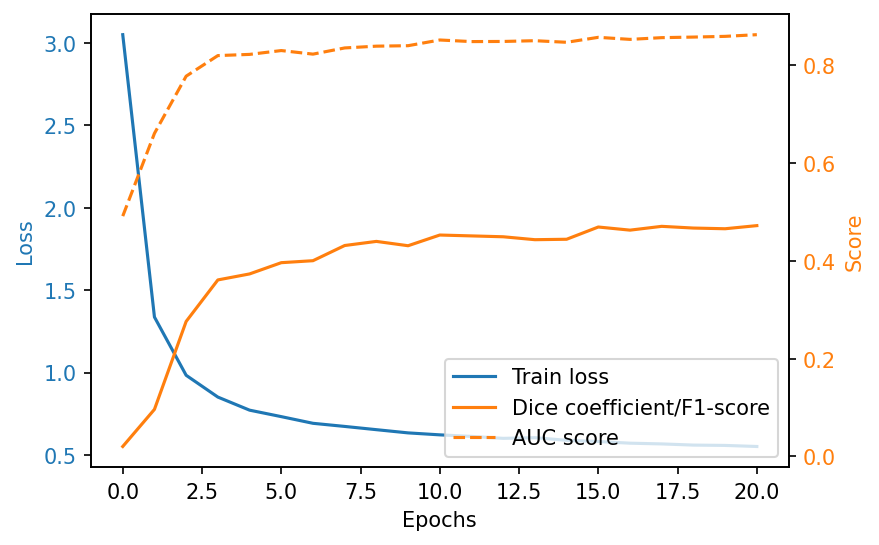

In [19]:
import matplotlib.lines as mlines

# specify colors for evaluation metrics
lossColor = "C0"
scoreColor = "C1"

# plot loss and score on different y axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(losses, color=lossColor)
ax2.plot(f1s, color=scoreColor)
ax2.plot(aucs, color=scoreColor, linestyle="dashed")

# configure axis labels and colors
ax1.set_ylabel("Loss", color=lossColor)
ax1.tick_params(axis='y', labelcolor=lossColor)
ax2.set_ylabel("Score", color=scoreColor)
ax2.tick_params(axis='y', labelcolor=scoreColor)
ax1.set_xlabel("Epochs")

# add a legend to the figure
legendItemLoss = mlines.Line2D([], [], color=lossColor, label="Train loss")
legendItemF1 = mlines.Line2D([], [], color=scoreColor, label="Dice coefficient/F1-score")
legendItemAuc = mlines.Line2D([], [], color=scoreColor, linestyle="dashed", label="AUC score")
plt.legend(handles=[legendItemLoss, legendItemF1, legendItemAuc], loc="best")

plt.show()

In the figure above we clearly see that the loss decreases over the epochs while both scores increase. This shows that the loss is a proxy for the two evaluation metrics. Furthermore, for the initial random model at epoch 0 the Dice coefficient is close to 0 since almost no true positives exist and the AUC score is close to 0.5 which is the performance of a random classifier.

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [20]:
# load the last model
model.load_state_dict(torch.load("model_state_epoch_" + str(epochs) + ".pt"))
_ = model.eval() # set model to eval mode

In [22]:
def undo_normalization(x):
    """Reverts the image normalization performed in loading the pascalVOC dataset

    Parameters
    ----------
    x : torch.tensor
        Image tensor of shape (3, height, width)
    
    Returns
    -------
    torch.tensor
        unnormalized Image tensor of shape (3, height, width)
    """
    channelStds = torch.tensor(train_data.tf.transforms[1].std).unsqueeze(1).unsqueeze(1)
    channelMeans = torch.tensor(train_data.tf.transforms[1].mean).unsqueeze(1).unsqueeze(1)
    return x * channelStds + channelMeans

def plot_segmentation(seg):
    """Plots the given pascalVOC segmentation map with appropriate colors
    
    Parameters
    ----------
    seg : torch.tensor
        Segmentation map tensor of shape (height, width)
    """
    colormap = train_data.get_pascal_labels() # obtain the colormap
    # initialize colored segmentation map
    colored_seg = torch.zeros((seg.shape[0], seg.shape[1], colormap.shape[1]), dtype=int)
    # set colors for each class
    for i in range(len(colormap)):
        colored_seg[seg == i] = torch.tensor(colormap[i])
    # show colored segmentation map
    plt.imshow(colored_seg)
    plt.axis("off") # remove axes

def plot_row(i, samples, x, y, y_pred):
    """Visualizes a pascalVOC input image, its true segmentation map and its predicted segmentation map

    Plots this sample as a row of a matplotlib.pyplot.subplot.

    Parameters
    ----------
    i : int
        The row of the subplot to plot in
    samples : int
        The number of rows to plot in total
    x : torch.tensor
        Input image tensor of shape (3, height, width)
    y : torch.tensor
        True segmentation map tensor of shape (height, width)
    y_pred : torch.tensor
        Predicted segmentation map tensor of shape (height, width)
    """
    x = undo_normalization(x) # revert normalization
    plots_per_sample = 3
    
    # plot image
    plt.subplot(samples, plots_per_sample, i * plots_per_sample + 1)
    plt.imshow(x.permute(1, 2, 0)) # fix color dimension
    plt.axis("off") # remove axis
    # show heading for fist row
    if i == 0:
        plt.title("Image")
    
    # plot true segmentation map
    plt.subplot(samples, plots_per_sample, i * plots_per_sample + 2)
    plot_segmentation(y)
    # show heading for fist row
    if i == 0:
        plt.title("True segmentation")
    
    # plot predicted segmentation map
    plt.subplot(samples, plots_per_sample, i * plots_per_sample + 3)
    plot_segmentation(y_pred)
    # show heading for fist row
    if i == 0:
        plt.title("Predicted segmentation")

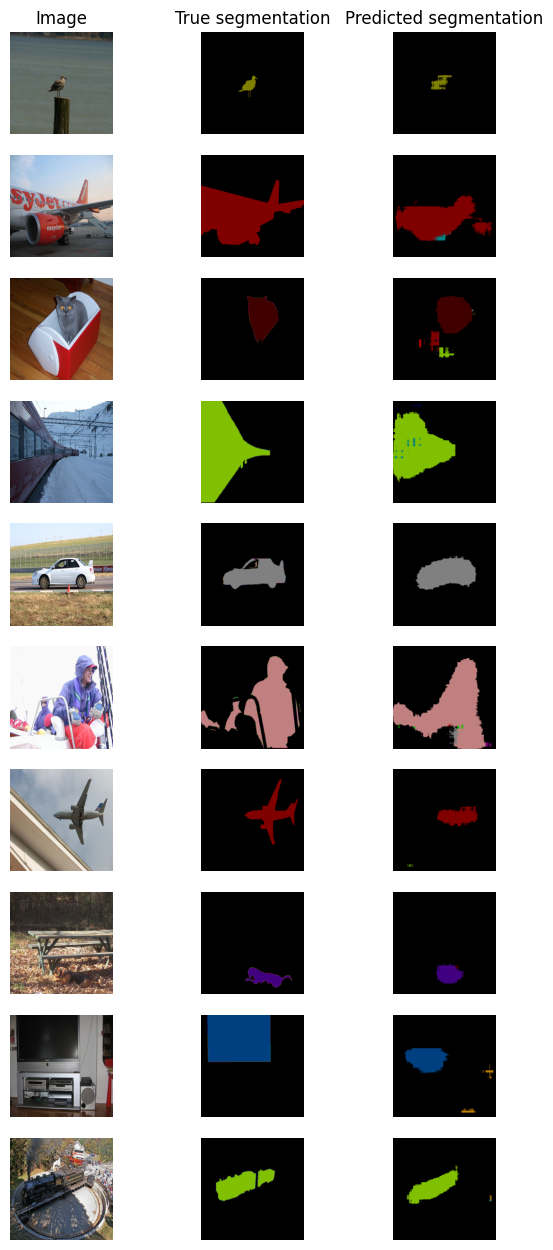

In [23]:
samples = 10 # set number of samples to plot
indices = np.random.randint(len(train_data), size=samples) # pick random samples

plt.figure(figsize=(7,16)) # specify figure size

# iterate through samples
for i in range(samples):
    x, y = train_data[indices[i]] # get input and target segmentation map
    # get predicted segmentation map as a numpy array
    y_pred = torch.argmax(model(x.cuda().unsqueeze(dim=0)), dim=1).squeeze().cpu().numpy()

    plot_row(i, samples, x, y, y_pred) # plot the current sample

plt.show()

The above visualizations show that the overall type, place and size of objects is mostly correctly predicted by the model. It only misses the fine contours of the objects and contours generally appear rather noisy. This is probably due to the large filter in the transposed convolutional layer and the shallow ResNet that was used.